<a href="https://colab.research.google.com/github/WellingtonLandim/wellingtonlandim.github.io/blob/main/Sistema_Recomendacao/Sistema_Recomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Recomendação com Deep Learning - Keras e SKLearn


In [1]:
import os
import numpy as np
import cv2
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import GlobalMaxPooling2D
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf


In [2]:
# Configuração do modelo ResNet50
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.trainable = False
model = tf.keras.Sequential([
    model,
    GlobalMaxPooling2D()
])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 2048)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [3]:
# Função para extrair características de uma imagem
def extract_feature(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = np.array(img)
    expand_img = np.expand_dims(img, axis=0)
    pre_img = preprocess_input(expand_img)
    result = model.predict(pre_img).flatten()
    normalized_result = result / np.linalg.norm(result)
    return normalized_result



In [4]:
# Função para obter dados de todas as classes dinamicamente
def get_class_data(base_dir, model):
    class_data = {}

    for root, dirs, files in os.walk(base_dir):
        class_name = os.path.basename(root)  # Nome da classe é o nome da pasta
        feature_list = []

        # Filtrar apenas arquivos de imagem
        image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Se não houver imagens, pule o diretório
        if not image_files:
            continue

        # Extrair características para todas as imagens da classe
        for image_file in image_files:
            image_path = os.path.join(root, image_file)
            try:
                features = extract_feature(image_path, model)
                feature_list.append(features)
            except Exception as e:
                print(f"Erro ao processar {image_path}: {e}")

        # Adicionar dados da classe ao dicionário
        if feature_list:
            class_data[class_name] = {
                "features": feature_list,
                "image_paths": [os.path.join(root, file) for file in image_files],
            }

    return class_data

In [5]:
# Função para recomendar produtos
def recommend_products(image_path, class_data, neighbors_models, model):
    """
    Recomenda produtos semelhantes com base na imagem fornecida.

    Args:
        image_path (str): Caminho da imagem para consulta.
        class_data (dict): Dados das classes extraídas do diretório.
        neighbors_models (dict): Modelos NearestNeighbors para cada classe.
        model: Modelo usado para extração de características.

    Returns:
        dict: Um dicionário com classe detectada e imagens recomendadas.
    """
    try:
        input_feature = extract_feature(image_path, model)
        best_match_class = None
        min_distance = float('inf')

        # Detectar a classe com base na menor distância
        for class_name, data in class_data.items():
            features = data["features"]
            neighbors_model = neighbors_models[class_name]
            distances, _ = neighbors_model.kneighbors([input_feature])
            avg_distance = np.mean(distances)

            if avg_distance < min_distance:
                min_distance = avg_distance
                best_match_class = class_name

        if not best_match_class:
            print("Não foi possível detectar a classe.")
            return None

        # Obter os vizinhos mais próximos da classe detectada
        neighbors_model = neighbors_models[best_match_class]
        distances, indices = neighbors_model.kneighbors([input_feature])
        recommended_images = [class_data[best_match_class]["image_paths"][i] for i in indices[0][1:]]  # Exclui a própria imagem

        return {"class": best_match_class, "recommended_images": recommended_images}

    except Exception as e:
        print(f"Erro ao recomendar produtos: {e}")
        return None

# Importação dos dados para análise

In [7]:
!kaggle datasets download -d sunnykusawa/ecommerce-products-image-dataset

!unzip ecommerce-products-image-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/sunnykusawa/ecommerce-products-image-dataset
License(s): CC0-1.0
 82% 33.0M/40.4M [00:00<00:00, 90.4MB/s]
100% 40.4M/40.4M [00:00<00:00, 98.9MB/s]
Archive:  ecommerce-products-image-dataset.zip
  inflating: ecommerce products/jeans/1.jpg  
  inflating: ecommerce products/jeans/10.jpg  
  inflating: ecommerce products/jeans/100.jpg  
  inflating: ecommerce products/jeans/101.jpg  
  inflating: ecommerce products/jeans/102.jpg  
  inflating: ecommerce products/jeans/103.jpg  
  inflating: ecommerce products/jeans/104.jpg  
  inflating: ecommerce products/jeans/105.jpg  
  inflating: ecommerce products/jeans/106.jpg  
  inflating: ecommerce products/jeans/107.jpg  
  inflating: ecommerce products/jeans/108.jpg  
  inflating: ecommerce products/jeans/109.jpg  
  inflating: ecommerce products/jeans/11.jpg  
  inflating: ecommerce products/jeans/110.jpg  
  inflating: ecommerce products/jeans/111.jpg  
  inflating: ecommerce products/jeans/112.jpg

# Avaliação com o K Nearest Neighbors

In [8]:
# Diretório base contendo as classes
base_dir = "/content/ecommerce products"

# Obter dados de todas as classes dinamicamente
class_data = get_class_data(base_dir, model)

# Inicializar modelos NearestNeighbors para cada classe
neighbors_models = {}
for class_name, data in class_data.items():
    features = data["features"]
    neighbors_model = NearestNeighbors(n_neighbors=6, algorithm="brute", metric="euclidean")
    neighbors_model.fit(features)
    neighbors_models[class_name] = neighbors_model

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

# Seleção da imagem para análise

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Classe detectada: tshirt
Produtos recomendados:


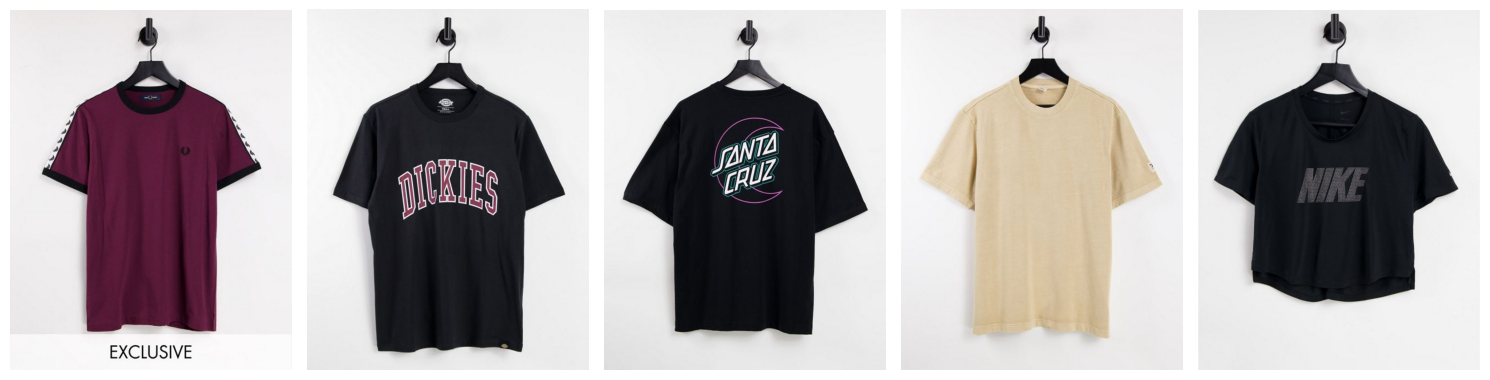

In [20]:
# Exemplo de uso

#Selecionar a imagem:
new_image_path = "/content/ecommerce products/tshirt/111.jpg"


recommendation = recommend_products(new_image_path, class_data, neighbors_models, model)

if recommendation:
    print(f"Classe detectada: {recommendation['class']}")
    print("Produtos recomendados:")

    # Exibir imagens recomendadas lado a lado
    fig, axes = plt.subplots(1, len(recommendation["recommended_images"]), figsize=(15, 5))
    for i, image_path in enumerate(recommendation["recommended_images"]):
        try:
            img = mpimg.imread(image_path)
            axes[i].imshow(img)
            axes[i].axis('off')
        except Exception as e:
            print(f"Erro ao exibir a imagem {image_path}: {e}")
            axes[i].text(0.5, 0.5, "Erro ao carregar imagem", ha='center', va='center')

    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma recomendação encontrada.")